<a href="https://colab.research.google.com/github/chebbin/datasci_6_regression/blob/main/code/507_linear_regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install ucimlrepo


In [21]:
import pandas as pd
from ucimlrepo import fetch_ucirepo, list_available_datasets

In [81]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from statsmodels.stats.diagnostic import linear_rainbow
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
# fetch dataset
liver_disorders = fetch_ucirepo(id=60)

# data (as pandas dataframes)
df = liver_disorders.data.features


# metadata
print(liver_disorders.metadata)

# variable information
print(liver_disorders.variables)

df


{'uci_id': 60, 'name': 'Liver Disorders', 'repository_url': 'https://archive.ics.uci.edu/dataset/60/liver+disorders', 'data_url': 'https://archive.ics.uci.edu/static/public/60/data.csv', 'abstract': 'BUPA Medical Research Ltd. database donated by Richard S. Forsyth', 'area': 'Health and Medicine', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 345, 'num_features': 5, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['drinks'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2016, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C54G67', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'The first 5 variables are all blood tests which are thought to be sensitive to liver disorders that might arise from excessive alcohol consumption. Each line in the dataset constitutes the record of a single male individual.\n\nImportant note: The 7

,mcv,alkphos,sgpt,sgot,gammagt
0,85,92,45,27,31
1,85,64,59,32,23
2,86,54,33,16,54
3,91,78,34,24,36
4,87,70,12,28,10
...,...,...,...,...,...
340,99,75,26,24,41
341,96,69,53,43,203
342,98,77,55,35,89
343,91,68,27,26,14


In [ ]:
df.describe()

SIMPLE LINEAR REGRESSION MODEL

The variable "drinks" according to the data dictionary of the dataset represents the number of half-pint equivalents of alcoholic beverages drunk per day. I had wanted to use this as the dependent variable, which would show the relationship between one of the liver related lab values and the number of drinks drunk per day. However, that variable did not appear in the dataset, and I don't understand why. So instead I looked at the relationship between SGOT and SGPT. These are enzyme tests. SGPT is found predominantly in the liver, while SGOT is found in the kidney, muscles, heart and brain. So using the SGOT as the independent variable, I looked at whether that value was a predictor of the SGPT level which I designated as the dependent variable. Even before running the test I figured there would be a strong correlation, but as the SGOT enzyme includes more organs, it would be significant but not complete.

In [51]:
# Fit the regression model
X = sm.add_constant(df['sgot'])  # Adds a constant term to the predictor
print(X)
model = sm.OLS(df['sgpt'], X)
print(model)


     const  sgot
0      1.0    27
1      1.0    32
2      1.0    16
3      1.0    24
4      1.0    28
..     ...   ...
340    1.0    24
341    1.0    43
342    1.0    35
343    1.0    26
344    1.0    45

[345 rows x 2 columns]


In [53]:
results = model.fit()
# Print summary of the regression
print(results.summary())

residuals = results.resid
fitted = results.fittedvalues


                            OLS Regression Results                            
Dep. Variable:                   sgpt   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     414.4
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           5.82e-61
Time:                        20:10:46   Log-Likelihood:                -1377.4
No. Observations:                 345   AIC:                             2759.
Df Residuals:                     343   BIC:                             2766.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.9336      1.875     -2.631      0.0

Adjusted R-squared value of 0.546 shows that 54.6% of the variability in the dependent variable can be explained by the regression model.

P value of 0.000 indicates that the null hypothesis is rejected, and the test is statistically significant. In this case, the SGPT level is significantly affected by the SGOT level.

In [54]:
### Assessing linearity of the relationship
stat, p_value = linear_rainbow(results)
print(f"Rainbow Test: stat={stat}, p-value={p_value}")

Rainbow Test: stat=1.064107855526583, p-value=0.3424660829323518


P value of .342 is greater than .05 which indicates an linear relationship between the two types of enzymes.


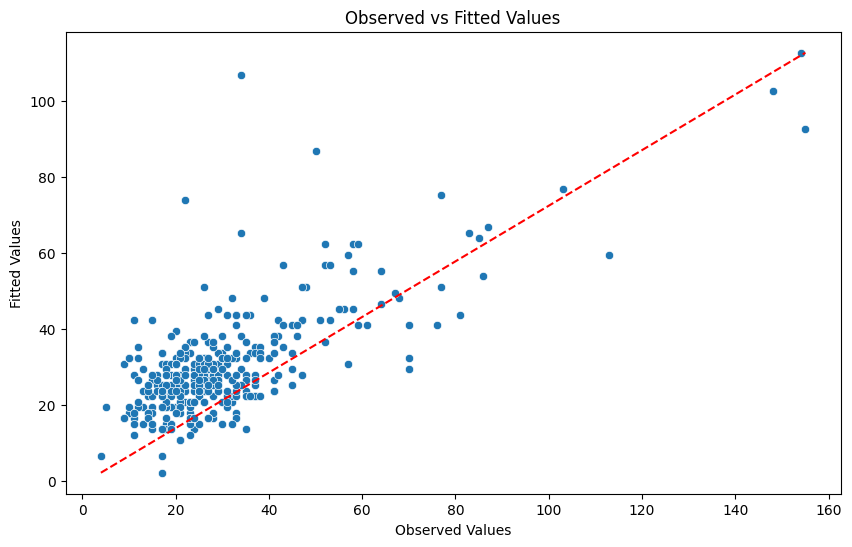

In [55]:
## A significant p-value indicates that the relationship is not linear.
# Plot observed vs fitted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['sgpt'], y=fitted)
plt.xlabel('Observed Values')
plt.ylabel('Fitted Values')
plt.title('Observed vs Fitted Values')
plt.plot([min(df['sgpt']), max(df['sgpt'])], [min(fitted), max(fitted)], color='red', linestyle='--')
plt.show()

Visual regression line shows strong but not complete dependence of the SGPT on SGOT.

MULTIPLE LINEAR REGRESSION MODEL

The other variables in the dataset are:

mcv- mean corpuscular volume- measures the average size of blood cells. Along with other tests can help determine anemia, liver disease, or other conditions

alkphos- measures the amount of alkaline phosphatase in the body- an enzyme found in many parts of the body including liver, bones, kidneys, and digestive system

gammagt- gamma-glutamyl transferase (GGT) test measures the enzyme by the same name which is found throughout the body, but mostly in the liver. When the liver is damaged, GGT may leak into the blood stream. High GGT in the blood may be a sign of liver disease.

In [68]:
# First create a new variable that includes all the independent variables
liver_function_tests = df[['mcv','alkphos', 'sgot', 'gammagt']]
liver_function_tests

,mcv,alkphos,sgot,gammagt
0,85,92,27,31
1,85,64,32,23
2,86,54,16,54
3,91,78,24,36
4,87,70,28,10
...,...,...,...,...
340,99,75,24,41
341,96,69,43,203
342,98,77,35,89
343,91,68,26,14


In [69]:
# Fit the regression model
X = sm.add_constant(liver_function_tests)  # Adds a constant term to the predictor
print(X)
model = sm.OLS(df['sgpt'], X)
print(model)

     const  mcv  alkphos  sgot  gammagt
0      1.0   85       92    27       31
1      1.0   85       64    32       23
2      1.0   86       54    16       54
3      1.0   91       78    24       36
4      1.0   87       70    28       10
..     ...  ...      ...   ...      ...
340    1.0   99       75    24       41
341    1.0   96       69    43      203
342    1.0   98       77    35       89
343    1.0   91       68    26       14
344    1.0   98       99    45       65

[345 rows x 5 columns]


In [70]:
results = model.fit()
# Print summary of the regression
print(results.summary())

residuals = results.resid
fitted = results.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                   sgpt   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     111.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.77e-60
Time:                        20:34:26   Log-Likelihood:                -1369.8
No. Observations:                 345   AIC:                             2750.
Df Residuals:                     340   BIC:                             2769.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0552     14.555      0.210      0.8

Adjusted R-squared value of 0.562 (compared to 0.546 when only using SGOT as the independent variable) shows 56.2% of the variability in the dependent variable can be explained by the regression model, so slightly higher than before.

P values of 0.000 for SGOT and gammagt indicates that the null hypothesis is rejected, and the test is statistically significant. In this case, the SGPT and the gammagt level is significantly affected by the SGOT level.

P values for mcv and alkphos are higher than .05 which indicates that we cannot conclude that these independent variables affects the dependent variable of SGPT.

In [71]:
### Assessing linearity of the relationship
stat, p_value = linear_rainbow(results)
print(f"Rainbow Test: stat={stat}, p-value={p_value}")

Rainbow Test: stat=1.4672435054482056, p-value=0.006494685146230274


P value of .006 is less than than .05 which indicates a non-linear relationship between the two types of enzymes.

Based on the multiple linear regression results, we will use a model that only includes the independent variables that are significant, which are SGOT and gammagt.

In [75]:
# First create a new variable that includes all the independent variables
liver_function_tests2 = df[['sgot', 'gammagt']]
liver_function_tests2

,sgot,gammagt
0,27,31
1,32,23
2,16,54
3,24,36
4,28,10
...,...,...
340,24,41
341,43,203
342,35,89
343,26,14


In [79]:
# Fit the regression model
X = sm.add_constant(liver_function_tests2)  # Adds a constant term to the predictor
print(X)
model2 = sm.OLS(df['sgpt'], X)
print(model)

     const  sgot  gammagt
0      1.0    27       31
1      1.0    32       23
2      1.0    16       54
3      1.0    24       36
4      1.0    28       10
..     ...   ...      ...
340    1.0    24       41
341    1.0    43      203
342    1.0    35       89
343    1.0    26       14
344    1.0    45       65

[345 rows x 3 columns]


In [80]:
results2 = model2.fit()
# Print summary of the regression
print(results2.summary())

residuals = results2.resid
fitted = results2.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                   sgpt   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     222.0
Date:                Sun, 19 Nov 2023   Prob (F-statistic):           1.60e-62
Time:                        21:00:30   Log-Likelihood:                -1370.5
No. Observations:                 345   AIC:                             2747.
Df Residuals:                     342   BIC:                             2759.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.9647      1.859     -2.133      0.0

Adjusted R-squared value of 0.562 shows that 56.2% of the variability in the dependent variable can be explained by the regression model, which is unchanged compared to when using all of the variables.

P values of 0.000 for both SGOT and gammagt indicate that the null hypothesis is rejected, and the test is statistically significant for both of these variables.

In [82]:
# Checking multicollinearity using VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVIF Data:")
print(vif_data)


VIF Data:
  Variable       VIF
0    const  7.152206
1     sgot  1.385788
2  gammagt  1.385788


All VIF numbers are less than 10, so there are neither independent variable is highly correlated with the other.